<a href="https://colab.research.google.com/github/drl1001/hello-world/blob/master/Body%26Fins_Heating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup



In [1]:
!pip install pygasflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 989.8 kB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from google.colab import drive
import os

from pygasflow.shockwave import shock_angle_from_mach_cone_angle, max_theta_c_from_mach, max_theta_from_mach
from pygasflow.solvers.shockwave import conical_shockwave_solver, shockwave_solver
from pygasflow.isentropic import get_ratios_from_mach, pressure_ratio, temperature_ratio, density_ratio, m_from_prandtl_meyer_angle, prandtl_meyer_angle

In [3]:
Rgas = 287
gm1 = 0.401
Pr = 0.70
recovery = np.sqrt(Pr)
cp = 1005
SB_const = 5.67e-8
T_rad_background = 298

In [4]:
!fusermount -u drive

fusermount: failed to unmount /content/drive: No such file or directory


In [5]:
#
drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)
os.listdir()
os.chdir("/content/gdrive")
os.listdir()
os.chdir("Shareddrives/Cambridge University Spaceflight")


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [ ]:
os.chdir("108 Griffin I")

In [ ]:
os.chdir("01 Docs")

In [ ]:
os.chdir("03 Aerodynamics")

In [ ]:
os.chdir("Aerothermal design")

In [ ]:
import pandas as pd
csvfile = "Griffin_Prelim_Flight_Profile.csv"

pd_csv = pd.read_csv(csvfile)

print(pd_csv.columns)
max_time = 200 * 100
get_every = 50

time_list = np.array(pd_csv.loc[:, "# Time (s)"][:max_time:get_every])
altitude_list = np.array(pd_csv.loc[:, " Z (m)"][:max_time:get_every])
speed_list = np.array([
    np.linalg.norm([pd_csv.loc[:, " Vx (m/s)"][i], pd_csv.loc[:, " Vy (m/s)"][i], pd_csv.loc[:, " Vz (m/s)"][i]])
    for i in range(len(pd_csv.loc[:, " Vx (m/s)"]))
    ][:max_time:get_every])
acceleration_list = np.array([
    np.linalg.norm([pd_csv.loc[:, " Ax (m/s2)"][i], pd_csv.loc[:, " Ay (m/s2)"][i], pd_csv.loc[:, " Az (m/s2)"][i]])
    for i in range(len(pd_csv.loc[:, " Ax (m/s2)"]))
    ][:max_time:get_every])
mach_list = np.array(pd_csv.loc[:, " Mach Number"][:max_time:get_every])
pressure_list = np.array(pd_csv.loc[:, " Pressure (Pa)"][:max_time:get_every])
density_list = np.array(pd_csv.loc[:, ' Density (kg/m³)'][:max_time:get_every])
temperature_list = pressure_list / (Rgas * density_list)

trajectory = {
    "time": time_list,
    "altitude": altitude_list,
    "acceleration": acceleration_list,
    "speed": speed_list,
    "mach": mach_list,
    "pressure": pressure_list,
    "density": density_list,
    "temperature": temperature_list
}

Index(['# Time (s)', ' X (m)', ' Y (m)', ' Z (m)', ' Vx (m/s)', ' Vy (m/s)',
       ' Vz (m/s)', ' Ax (m/s2)', ' Ay (m/s2)', ' Az (m/s2)', ' e0', ' e1',
       ' e2', ' e3', ' Mach Number', ' Dynamic Pressure (Pa)',
       ' Pressure (Pa)', ' Density (kg/m³)'],
      dtype='object')


In [ ]:
def viscosity_sutherland(T, T0):
  mu0 = 1.716e-5
  Su = 110.4
  ratio = np.power(T/T0, 1.5) * ((T0+Su) / (T+Su))
  return(mu0*ratio)

def conductivity_sutherland(T, T0):
  k0 = 0.0339
  Su = 350
  ratio = np.power(T/1494, 1.5) * ((1494+Su) / (T+Su))
  return(k0 * ratio)

# Vehicle properties

In [ ]:
### Material properties

alu = {
    "density":2700,
    "SHC":896,
    #"emissivity":0.15,
    "emissivity":0.8,   # Using a TiO2 coating
    "thermal conductivity":167
}

steel = {
    "density":8000,
    "SHC":500,
    "emissivity":0.7,
    "thermal conductivity":15
}

In [ ]:
### Nosecone properties

nosecone_tip_angle = 11.5

In [ ]:
### Fin properties

"""
Fin is divided into "leading edge LE", a radiused edge
"wedge1" the expanding section of the wedge
"wedge2" the straight section of the wedge
"wedge3" the contracting section of the wedge

"""

LE_radius = 3.55e-3
LE_thermal_inertia = 1e-3 * steel["density"] * steel["SHC"]
# Thickness * density * specific heat capacity
LE_emissivity = steel["emissivity"]

panel_thickness = 1e-3

wedge1_length = 0.15875
wedge1_angle = 5
wedge1_thermal_inertia = panel_thickness * alu["density"] * alu["SHC"]
wedge1_emissivity = alu["emissivity"]
wedge1_n_stations = 8

wedge2_length = 0.6975
wedge2_thermal_inertia = panel_thickness * alu["density"] * alu["SHC"]
wedge2_emissivity = alu["emissivity"]
wedge2_n_stations = 35

wedge3_length = 0.15875
wedge3_angle = 5
wedge3_thermal_inertia = panel_thickness * alu["density"] * alu["SHC"]
wedge3_emissivity = alu["emissivity"]
wedge3_n_stations = 8

In [ ]:
### Body properties

body_radius = 0.375/2
bay_thickness = 0.5e-3
propellant_drain_time = 32.8

upper_bay_length = 1.905
upper_bay_thermal_inertia = bay_thickness * steel["density"] * steel["SHC"]
upper_bay_emissivity = steel["emissivity"]
upper_bay_thermal_conductivity = steel["thermal conductivity"]
upper_bay_n_stations = 19

ox_tank_length = 2.037
ox_tank_thickness = 2e-3
lox_temperature_K = 145
ox_tank_thermal_inertia = ox_tank_thickness * alu["density"] * alu["SHC"]
ox_tank_radial_thermal_resistance = np.log(body_radius/(body_radius - ox_tank_thickness)) / (2 * np.pi * alu["thermal conductivity"])
ox_tank_emissivity = alu["emissivity"]
ox_tank_thermal_conductivity = alu["thermal conductivity"]
ox_tank_n_stations = 20

intertank_bay_length = 0.510
intertank_bay_thermal_inertia = bay_thickness * steel["density"] * steel["SHC"]
intertank_bay_emissivity = alu["emissivity"]
intertank_bay_thermal_conductivity = steel["thermal conductivity"]
intertank_bay_n_stations = 5

fuel_tank_length = 2.437
fuel_tank_thickness = 2e-3
fuel_temperature_K = 298
fuel_tank_thermal_inertia = fuel_tank_thickness * alu["density"] * alu["SHC"]
fuel_tank_thermal_resistance = np.log(body_radius/(body_radius - fuel_tank_thickness)) / (2 * np.pi * alu["thermal conductivity"])
fuel_tank_emissivity = alu["emissivity"]
fuel_tank_thermal_conductivity = alu["thermal conductivity"]
fuel_tank_n_stations = 24

aft_bay_length = 1.015
aft_bay_thermal_inertia = bay_thickness * steel["density"] * steel["SHC"]
aft_bay_emissivity = alu["emissivity"]
aft_bay_thermal_conductivity = steel["thermal conductivity"]
aft_bay_n_stations = 10

fin_top_position = upper_bay_length + ox_tank_length + intertank_bay_length + fuel_tank_length

bay_tank_thermal_contact_conductivity = 2000  # W/m2K
bay_tank_overlap_length = 1e-2

bay_tank_thermal_resistance = 1 / (bay_tank_thermal_contact_conductivity * (bay_tank_overlap_length * 2 * np.pi * body_radius))

upper_bay_axial_thermal_resistance = ((upper_bay_length/(upper_bay_n_stations-1)) / 
                                      (upper_bay_thermal_conductivity * 2 * np.pi * body_radius * bay_thickness))

ox_tank_axial_thermal_resistance = ((ox_tank_length/(ox_tank_n_stations-1)) / 
                                      (ox_tank_thermal_conductivity * 2 * np.pi * body_radius * ox_tank_thickness))

intertank_bay_axial_thermal_resistance = ((intertank_bay_length/(intertank_bay_n_stations-1)) / 
                                      (intertank_bay_thermal_conductivity * 2 * np.pi * body_radius * bay_thickness))

fuel_tank_axial_thermal_resistance = ((fuel_tank_length/(fuel_tank_n_stations-1)) / 
                                      (fuel_tank_thermal_conductivity * 2 * np.pi * body_radius * fuel_tank_thickness))

aft_bay_axial_thermal_resistance = ((aft_bay_length/(aft_bay_n_stations-1)) / 
                                      (aft_bay_thermal_conductivity * 2 * np.pi * body_radius * bay_thickness))

In [ ]:
print(bay_tank_thermal_resistance)

0.042441318157838755


# Flow behind nose shock

Behind the nosecone conical shock, the flow re-expands and re-accelerates at a higher temperature. This results in a new far-field temperature

In [ ]:
nosecone_shock = {"time":trajectory["time"]}

postshock_mach = []
postshock_temp_static = []
postshock_pressure_static = []

expanded_mach = []
expanded_temp_static = []
expanded_pressure_static = []

for step in range(len(nosecone_shock["time"])):
  M1 = trajectory["mach"][step]
  if step % 10 == 0:
    print(M1, trajectory["altitude"][step])
  if M1 <= 1:
    postshock_mach.append(M1)
    postshock_temp_static.append(trajectory["temperature"][step])
    postshock_pressure_static.append(trajectory["pressure"][step])

    expanded_mach.append(trajectory["mach"][step])
    expanded_temp_static.append(trajectory["temperature"][step])
    expanded_pressure_static.append(trajectory["pressure"][step])
  else:
    max_theta_c = max_theta_c_from_mach(M1)[1]
    if nosecone_tip_angle < max_theta_c:
      # Use cone shock
      cone_shock_data = conical_shockwave_solver(M1, param_name="theta_c", param_value=nosecone_tip_angle, gamma=1.401, to_dict=True)

      nu_cone = prandtl_meyer_angle(cone_shock_data["mc"])
      mach_expand_body = m_from_prandtl_meyer_angle(nu_cone + nosecone_tip_angle)

      stag_ratios_shock = get_ratios_from_mach(cone_shock_data["mc"], gamma=1.401)
      stag_ratios_expand = get_ratios_from_mach(mach_expand_body, gamma=1.401)

      Ts_expand = trajectory["temperature"][step] * (stag_ratios_expand[2] / stag_ratios_shock[2]) * cone_shock_data["Tc_T1"]
      ps_expand = trajectory["pressure"][step] * (stag_ratios_expand[0] / stag_ratios_shock[0]) * cone_shock_data["pc_p1"]

      
      postshock_mach.append(cone_shock_data["mc"])
      postshock_temp_static.append(trajectory["temperature"][step] * cone_shock_data["Tc_T1"])
      postshock_pressure_static.append(trajectory["pressure"][step] * cone_shock_data["pc_p1"])

      expanded_mach.append(mach_expand_body)
      expanded_temp_static.append(Ts_expand)
      expanded_pressure_static.append(ps_expand)


    else:
      norm_shock_data = shockwave_solver(p1_name="m1", p1_value=M1, p2_name="beta", p2_value=90, gamma=1.401, to_dict=True)

      postshock_mach.append(norm_shock_data["m2"])
      postshock_temp_static.append(trajectory["temperature"][step] * norm_shock_data["pr"])
      postshock_pressure_static.append(trajectory["pressure"][step] * norm_shock_data["tr"])

      expanded_mach.append(norm_shock_data["m2"])
      expanded_temp_static.append(trajectory["temperature"][step] * norm_shock_data["pr"])
      expanded_pressure_static.append(trajectory["pressure"][step] * norm_shock_data["tr"])

nosecone_shock["post shock mach"] = postshock_mach
nosecone_shock["post shock temperature static"] = postshock_temp_static
nosecone_shock["post shock pressure static"] = postshock_pressure_static

nosecone_shock["expanded mach"] = expanded_mach
nosecone_shock["expanded temperature static"] = expanded_temp_static
nosecone_shock["expanded pressure static"] = expanded_pressure_static

postshock_mach, postshock_temp_static, postshock_pressure_static = [], [], []
expanded_mach, expanded_temp_static, expanded_pressure_static = [], [], []

0.0 600.0
0.665812 1145.585502
1.408306 2861.716097
1.879764 5446.463765
2.538527 8849.631802
3.409435 13261.306279
4.524789 19067.706096
5.214647 26358.333623
4.896247 34009.915321
4.532351 41386.562451
4.243246 48508.491922
4.193853 55381.787509
4.196921 62008.525067
4.19434 68389.533708
4.164472 74525.155996
4.103422 80415.529296
3.928998 86060.71658
3.754575 91460.734775
3.580153 96615.584023
3.40573 101525.264462
3.231307 106189.776232
3.056885 110609.119473
2.882462 114783.294327
2.70804 118712.300934
2.533618 122396.139437
2.359195 125834.80998
2.184773 129028.312707
2.010351 131976.647765
1.83593 134679.815298
1.661508 137137.815446
1.487086 139350.648347
1.312665 141318.314141
1.138243 143040.812961
0.963822 144518.144964
0.789401 145750.310378
0.61498 146737.309356
0.440559 147479.141972
0.266138 147975.808279
0.091717 148227.308313
0.082704 148233.642092


# Flow over fins
The flow over the fins includes a number of shock systems:
- a local shock on the rounded leading edge
- an oblique shock on the leading edge as a whole
- two sets of Prandtl-Meyer expansions on the two corners of the wedge

https://www.abcm.org.br/anais/cobem/2005/PDF/COBEM2005-1353.pdf

In [ ]:
from pygasflow.solvers.isentropic import isentropic_solver
fins_flow = {}
fins_flow["time"] = trajectory["time"]

LE_temp_static = []
LE_temp_stag = []
LE_temp_recovery = []
LE_pressure_static = []
LE_HTC = []

wedge1_positions = []
wedge1_distances = []
wedge1_temp_recovery = [[] for station in range(wedge1_n_stations)]
wedge1_HTC = [[] for station in range(wedge1_n_stations)]

wedge2_positions = []
wedge2_distances = []
wedge2_temp_recovery = [[] for station in range(wedge2_n_stations)]
wedge2_HTC = [[] for station in range(wedge2_n_stations)]

wedge3_positions = []
wedge3_distances = []
wedge3_temp_recovery = [[] for station in range(wedge3_n_stations)]
wedge3_HTC = [[] for station in range(wedge3_n_stations)]

finshock_angle = []
finshock_mach = []
finshock_static_temp = []
finshock_static_pressure = []

for station in range(1, wedge1_n_stations+1):
  wedge1_positions.append(station * wedge1_length / (wedge1_n_stations-1))
  wedge1_distances.append(station * wedge1_length / (wedge1_n_stations-1))

for station in range(1, wedge2_n_stations+1):
  wedge2_positions.append(wedge1_length + station * wedge2_length / (wedge2_n_stations-1))
  wedge2_distances.append(station * wedge2_length / (wedge2_n_stations-1))

for station in range(1, wedge3_n_stations+1):
  wedge3_positions.append(wedge1_length + wedge2_length + station * wedge3_length / (wedge3_n_stations-1))
  wedge3_distances.append(station * wedge3_length / (wedge3_n_stations-1))

for step in range(len(fins_flow["time"])):
  M1 = nosecone_shock["expanded mach"][step]
  T_up = nosecone_shock["expanded temperature static"][step]

  if M1 > 1:
    max_angle = max_theta_from_mach(M1, gamma=1.401)

  if M1 <= 1:
    # No shock is present - use all the simple values

    # Leading edge calculation
    stagnation_ratios = isentropic_solver("m", M1, gamma=1.401, to_dict=True)

    stag_temp = T_up / stagnation_ratios["pr"]
    recovery_LE = T_up * (1 + recovery*0.2005*np.power(M1,2))

    LE_temp_static.append(T_up)
    LE_pressure_static.append(nosecone_shock["expanded pressure static"][step])
    LE_temp_stag.append(stag_temp)
    LE_temp_recovery.append(recovery_LE)

    # Use Reynolds number argument, from Cengel pp384
    mu = viscosity_sutherland(T_up, stag_temp)
    D = 2 * LE_radius
    a = np.sqrt(1.401 * 287 * T_up)
    V = a * M1 
    rho = nosecone_shock["expanded pressure static"][step] / (287 * T_up)
    Re_LE = V * D * rho / mu
    Nu = (-6.124e-9 * np.power(Re_LE, 2)) + (3.805e-3 * Re_LE)
    k = conductivity_sutherland(T_up, stag_temp)
    HTC = Nu * k / D

    LE_HTC.append(HTC)

    # Get flow properties on each wedge section

    # Assume constant speed on all wedge section
    for station in range(wedge1_n_stations):
      y = wedge1_distances[station]
      Re = rho * V * y / mu
      HTC_w1_station = rho * V * cp * 0.0296 * np.power(Re, -0.2)
      
      wedge1_HTC[station].append(HTC_w1_station)
      wedge1_temp_recovery[station].append(recovery_LE)
    
    for station in range(wedge2_n_stations):
      y = wedge2_distances[station]
      Re = rho * V * y / mu
      HTC_w2_station = rho * V * cp * 0.0296 * np.power(Re, -0.2)
      
      wedge2_HTC[station].append(HTC_w2_station)
      wedge2_temp_recovery[station].append(recovery_LE)
    
    for station in range(wedge3_n_stations):
      y = wedge3_distances[station]
      Re = rho * V * y / mu
      HTC_w3_station = rho * V * cp * 0.0296 * np.power(Re, -0.2)
      
      wedge3_HTC[station].append(HTC_w3_station)
      wedge3_temp_recovery[station].append(recovery_LE)
    
    finshock_angle.append(90)
    finshock_mach.append(M1)
    finshock_static_temp.append(T_up)
    finshock_static_pressure.append(nosecone_shock["expanded pressure static"][step])

  else:
    # Normal or oblique shock
    if wedge1_angle > max_angle:
      norm_shock_data = shockwave_solver(p1_name="m1", p1_value=M1, p2_name="beta", p2_value=90, gamma=1.401, to_dict=True)
    else:
      norm_shock_data = shockwave_solver(p1_name="m1", p1_value=M1, p2_name="theta", p2_value=wedge1_angle, gamma=1.401, to_dict=True)
    stagnation_ratios = isentropic_solver("m", norm_shock_data["m2"], gamma=1.401, to_dict=True)

    static_temp = T_up * norm_shock_data["tr"]
    static_pressure = nosecone_shock["expanded pressure static"][step] * norm_shock_data["pr"]
    stag_temp = nosecone_shock["expanded pressure static"][step] * norm_shock_data["pr"] / stagnation_ratios["pr"]
    recovery_LE = static_temp * (1 + recovery*0.2005*np.power(norm_shock_data["m2"], 2))

    LE_temp_static.append(static_temp)
    LE_pressure_static.append(static_pressure)
    LE_temp_stag.append(stag_temp)
    LE_temp_recovery.append(recovery_LE)

    # Use Anderson method for HTC
    mu_LE = viscosity_sutherland(T_up, stag_temp)
    rho_LE = static_pressure / (287 * static_temp)

    dudx = (1/LE_radius) * np.sqrt(nosecone_shock["expanded pressure static"][step] * (norm_shock_data["pr"] - 1) / rho_LE)

    HTC = 0.570 * np.power(Pr, -0.6) * np.sqrt(rho_LE * mu_LE * dudx) * cp

    LE_HTC.append(HTC)

  
    # Get flow properties on each wedge section

    # Use Prandtl-Meyer for each section

    nu_wedge1 = prandtl_meyer_angle(norm_shock_data["m2"])
    mach_wedge2 = m_from_prandtl_meyer_angle(nu_wedge1 + wedge1_angle)
    mach_wedge3 = m_from_prandtl_meyer_angle(nu_wedge1 + wedge1_angle + wedge3_angle)

    stag_ratios_wedge2 = get_ratios_from_mach(mach_wedge2, gamma=1.401)
    stag_ratios_wedge3 = get_ratios_from_mach(mach_wedge3, gamma=1.401)

    p_static_wedge2 = static_pressure * (stag_ratios_wedge2[0] / stagnation_ratios["pr"])
    p_static_wedge3 = p_static_wedge2 * (stag_ratios_wedge3[0] / stag_ratios_wedge2[0])

    T_static_wedge2 = static_temp * (stag_ratios_wedge2[2] / stagnation_ratios["tr"])
    T_static_wedge3 = T_static_wedge2 * (stag_ratios_wedge3[2] / stag_ratios_wedge2[2])

    T_recovery_wedge2 = T_static_wedge2 * (1 + recovery*0.2005*np.power(mach_wedge2, 2))
    T_recovery_wedge3 = T_static_wedge3 * (1 + recovery*0.2005*np.power(mach_wedge3, 2))

    T_stag_wedge2 = T_static_wedge2 * stag_ratios_wedge2[2]
    T_stag_wedge3 = T_static_wedge3 * stag_ratios_wedge3[2]

    a_wedge1 = np.sqrt(1.401 * 287 * static_temp)
    a_wedge2 = np.sqrt(1.401 * 287 * T_static_wedge2)
    a_wedge3 = np.sqrt(1.401 * 287 * T_static_wedge3)

    V_wedge1 = a_wedge1 * norm_shock_data["m2"] 
    V_wedge2 = a_wedge2 * mach_wedge2
    V_wedge3 = a_wedge3 * mach_wedge3

    rho_wedge2 = p_static_wedge2 / (287 * T_static_wedge2)
    rho_wedge3 = p_static_wedge3 / (287 * T_static_wedge3)

    mu_wedge2 = viscosity_sutherland(T_static_wedge2, T_stag_wedge2)
    mu_wedge3 = viscosity_sutherland(T_static_wedge3, T_stag_wedge3)

    for station in range(wedge1_n_stations):
      y = wedge1_distances[station]
      Re = rho_LE * V_wedge1 * y / mu_LE
      HTC_w1_station = rho_LE * V_wedge1 * cp * 0.0296 * np.power(Re, -0.2)
      
      wedge1_HTC[station].append(HTC_w1_station)
      wedge1_temp_recovery[station].append(recovery_LE)
    
    for station in range(wedge2_n_stations):
      y = wedge2_distances[station]
      Re = rho_wedge2 * V_wedge2 * y / mu_wedge2
      HTC_w2_station = rho_wedge2 * V_wedge2 * cp * 0.0296 * np.power(Re, -0.2)
      
      wedge2_HTC[station].append(HTC_w2_station)
      wedge2_temp_recovery[station].append(T_recovery_wedge2)
    
    for station in range(wedge3_n_stations):
      y = wedge3_distances[station]
      Re = rho_wedge3 * V_wedge3 * y / mu_wedge3
      HTC_w3_station = rho_wedge3 * V_wedge3 * cp * 0.0296 * np.power(Re, -0.2)
      
      wedge3_HTC[station].append(HTC_w3_station)
      wedge3_temp_recovery[station].append(T_recovery_wedge3)
    
    finshock_angle.append(norm_shock_data["beta"])
    finshock_mach.append(norm_shock_data["m2"])
    finshock_static_temp.append(static_temp)
    finshock_static_pressure.append(static_pressure)


fins_flow["leading edge static temperature"] = np.array(LE_temp_static)
fins_flow["leading edge stagnation temperature"] = np.array(LE_temp_stag)
fins_flow["leading edge recovery temperature"] = np.array(LE_temp_recovery)
fins_flow["leading edge static pressure"] = np.array(LE_pressure_static)
fins_flow["leading edge HTC"] = np.array(LE_HTC)

fins_flow["wedge 1 station position"] = np.array(wedge1_positions)
fins_flow["wedge 2 station position"] = np.array(wedge2_positions)
fins_flow["wedge 3 station position"] = np.array(wedge3_positions)

fins_flow["wedge 1 recovery temperature"] = np.array(wedge1_temp_recovery)
fins_flow["wedge 1 HTC"] = np.array(wedge1_HTC)
fins_flow["wedge 2 recovery temperature"] = np.array(wedge2_temp_recovery)
fins_flow["wedge 2 HTC"] = np.array(wedge2_HTC)
fins_flow["wedge 3 recovery temperature"] = np.array(wedge3_temp_recovery)
fins_flow["wedge 3 HTC"] = np.array(wedge3_HTC)

fins_flow["angle of fin shock"] = np.array(finshock_angle)
fins_flow["mach behind fin shock"] = np.array(finshock_mach)
fins_flow["static temperature behind fin shock"] = np.array(finshock_static_temp)
fins_flow["static pressure behind shock"] = np.array(finshock_static_pressure)

LE_temp_static, LE_temp_stag, LE_temp_recovery, LE_pressure_static, LE_HTC = [],[],[],[],[]
wedge1_positions, wedge2_positions, wedge3_positions = [],[],[]
wedge1_temp_recovery, wedge2_temp_recovery, wedge3_temp_recovery = [],[],[]
wedge1_HTC, wedge2_HTC, wedge3_HTC = [],[],[]
finshock_angle, finshock_mach, finshock_static_temp, finshock_static_pressure = [],[],[],[]

/usr/local/lib/python3.9/dist-packages/pygasflow/isentropic.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 + (gamma - 1) / 2 * M**2) / ((gamma + 1) / 2))**((gamma + 1) / (2 * (gamma - 1)))) / M
<ipython-input-18-bacb9d307bae>:83: RuntimeWarning: divide by zero encountered in power
  HTC_w1_station = rho * V * cp * 0.0296 * np.power(Re, -0.2)
<ipython-input-18-bacb9d307bae>:83: RuntimeWarning: invalid value encountered in double_scalars
  HTC_w1_station = rho * V * cp * 0.0296 * np.power(Re, -0.2)
<ipython-input-18-bacb9d307bae>:91: RuntimeWarning: divide by zero encountered in power
  HTC_w2_station = rho * V * cp * 0.0296 * np.power(Re, -0.2)
<ipython-input-18-bacb9d307bae>:91: RuntimeWarning: invalid value encountered in double_scalars
  HTC_w2_station = rho * V * cp * 0.0296 * np.power(Re, -0.2)
<ipython-input-18-bacb9d307bae>:99: RuntimeWarning: divide by zero encountered in power
  HTC_w3_station = rho * V * cp * 0.0296 * np.power(Re, -0.2)
<ipy

## Fin heating results

Text(0.5, 1.0, 'Cold-surface heating rate (W/m2) on Griffin fins, nominal flight')

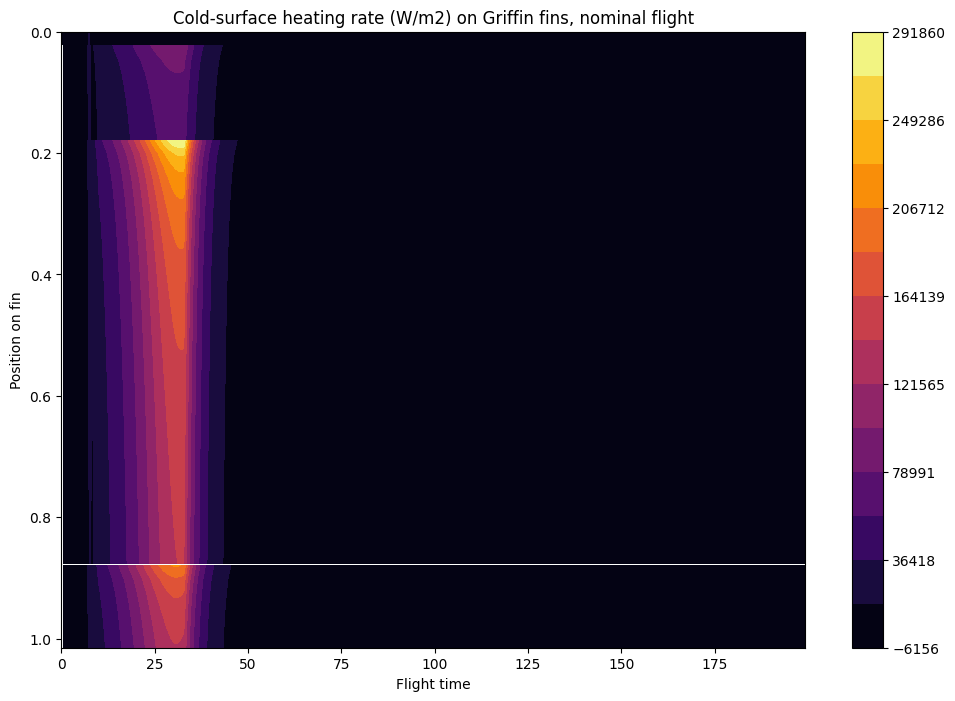

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
max_heatrate = max(
    np.nanmax((fins_flow["leading edge recovery temperature"]-298) * fins_flow["leading edge HTC"]),
    np.nanmax((fins_flow["wedge 1 recovery temperature"]-298)*fins_flow["wedge 1 HTC"]),
    np.nanmax((fins_flow["wedge 2 recovery temperature"]-298)*fins_flow["wedge 2 HTC"]),
    np.nanmax((fins_flow["wedge 3 recovery temperature"]-298)*fins_flow["wedge 3 HTC"])
)

min_heatrate = min(
    np.nanmin((fins_flow["leading edge recovery temperature"]-298) * fins_flow["leading edge HTC"]),
    np.nanmin((fins_flow["wedge 1 recovery temperature"]-298)*fins_flow["wedge 1 HTC"]),
    np.nanmin((fins_flow["wedge 2 recovery temperature"]-298)*fins_flow["wedge 2 HTC"]),
    np.nanmin((fins_flow["wedge 3 recovery temperature"]-298)*fins_flow["wedge 3 HTC"])
)

lvls = np.linspace(min_heatrate, max_heatrate, 15)

plt.contourf(fins_flow["time"],
             [0, fins_flow["wedge 1 station position"][0]],
             [(fins_flow["leading edge recovery temperature"]-298) * fins_flow["leading edge HTC"], 
              (fins_flow["leading edge recovery temperature"] - 298) * fins_flow["leading edge HTC"]],
             levels=lvls, cmap="inferno")

plt.contourf(fins_flow["time"],
             fins_flow["wedge 1 station position"], 
             (fins_flow["wedge 1 recovery temperature"]-298)*fins_flow["wedge 1 HTC"],
             levels=lvls, cmap="inferno")

plt.contourf(fins_flow["time"],
             fins_flow["wedge 2 station position"], 
             (fins_flow["wedge 2 recovery temperature"]-298)*fins_flow["wedge 2 HTC"], 
             levels=lvls, cmap="inferno")

plt.contourf(fins_flow["time"],
             fins_flow["wedge 3 station position"], 
             (fins_flow["wedge 3 recovery temperature"]-298)*fins_flow["wedge 3 HTC"], 
             levels=lvls, cmap="inferno")
plt.colorbar()
plt.ylim(0, 1.015)
plt.gca().invert_yaxis()
plt.xlabel("Flight time")
plt.ylabel("Position on fin")
plt.title("Cold-surface heating rate (W/m2) on Griffin fins, nominal flight")


# Flow over body tube

In [ ]:
def body_HTC_recovery_temps(n_stations, body_positions, body_HTC, body_recovery_temp, rho_body, V_body, mu_body, T_recovery_body):
  for station in range(n_stations):
    y = body_positions[station]
    Re_body = rho_body * V_body * y / mu_body

    if Re_body > 0:
      HTC = rho_body * V_body * cp * 0.0296 * np.power(Re_body, -0.2)
    else:
      HTC = 0
    
    body_HTC[station].append(HTC)
    body_recovery_temp[station].append(T_recovery_body)

In [ ]:
body_flow = {}
body_flow["time"] = trajectory["time"]
body_flow["main tube mach"] = nosecone_shock["expanded mach"]
body_flow["main tube static temperature"] = nosecone_shock["expanded temperature static"]

body_flow["fin shock mach"] = fins_flow["mach behind fin shock"]
body_flow["fin shock angle"] = fins_flow["angle of fin shock"]
body_flow["fin shock static temperature"] = fins_flow["static temperature behind fin shock"]

upper_bay_positions = np.linspace(1e-2, upper_bay_length, upper_bay_n_stations)
ox_tank_positions = np.linspace(upper_bay_length, upper_bay_length+ox_tank_length, ox_tank_n_stations)
intertank_bay_positions = np.linspace(upper_bay_length+ox_tank_length, 
                                      upper_bay_length+ox_tank_length+intertank_bay_length, intertank_bay_n_stations)
fuel_tank_positions = np.linspace(upper_bay_length+ox_tank_length+intertank_bay_length, 
                                  upper_bay_length+ox_tank_length+intertank_bay_length+fuel_tank_length, 
                                  fuel_tank_n_stations)
aft_bay_positions = np.linspace(upper_bay_length+ox_tank_length+intertank_bay_length+fuel_tank_length, 
                                  upper_bay_length+ox_tank_length+intertank_bay_length+fuel_tank_length+aft_bay_length, 
                                  aft_bay_n_stations)

print(upper_bay_positions, ox_tank_positions)

upper_bay_recovery_temperature = [[] for station in range(upper_bay_n_stations)]
upper_bay_HTC = [[] for station in range(upper_bay_n_stations)]

ox_tank_recovery_temperature = [[] for station in range(ox_tank_n_stations)]
ox_tank_HTC = [[] for station in range(ox_tank_n_stations)]

intertank_bay_recovery_temperature = [[] for station in range(intertank_bay_n_stations)]
intertank_bay_HTC = [[] for station in range(intertank_bay_n_stations)]

fuel_tank_recovery_temperature = [[] for station in range(fuel_tank_n_stations)]
fuel_tank_HTC = [[] for station in range(fuel_tank_n_stations)]

aft_bay_recovery_temperature = [[] for station in range(aft_bay_n_stations)]
aft_bay_HTC = [[] for station in range(aft_bay_n_stations)]


for step in range(len(fins_flow["time"])):
  M_body = body_flow["main tube mach"][step]
  T_static_body = body_flow["main tube static temperature"][step]
  p_static_body = nosecone_shock["expanded pressure static"][step]

  T_stag_body = T_static_body * (1 + 0.2005*np.power(M_body,2))
  T_recovery_body = T_static_body * (1 + recovery*0.2005*np.power(M_body,2))

  rho_body = p_static_body / (Rgas * T_static_body)

  mu_body = viscosity_sutherland(T_static_body, T_stag_body)
  a_body = np.sqrt(1.401 * Rgas * T_static_body)
  V_body = M_body * a_body

  body_HTC_recovery_temps(upper_bay_n_stations, upper_bay_positions, upper_bay_HTC, upper_bay_recovery_temperature,
                          rho_body, V_body, mu_body, T_recovery_body)

  body_HTC_recovery_temps(ox_tank_n_stations, ox_tank_positions, ox_tank_HTC, ox_tank_recovery_temperature,
                          rho_body, V_body, mu_body, T_recovery_body)

  body_HTC_recovery_temps(intertank_bay_n_stations, intertank_bay_positions, intertank_bay_HTC, intertank_bay_recovery_temperature,
                          rho_body, V_body, mu_body, T_recovery_body)

  body_HTC_recovery_temps(fuel_tank_n_stations, fuel_tank_positions, fuel_tank_HTC, fuel_tank_recovery_temperature,
                          rho_body, V_body, mu_body, T_recovery_body)
  
  # For the aft bay, work out the position of the shockwave
  finshock_mach = body_flow["fin shock mach"][step]
  finshock_static_temp = body_flow["fin shock static temperature"][step]
  finshock_static_pressure = fins_flow["static pressure behind shock"][step]

  horizontal_distance = body_radius
  vertical_distance = horizontal_distance * np.cos(np.deg2rad(body_flow["fin shock angle"][step]))

  for station in range(aft_bay_n_stations):
    if (aft_bay_positions[station] - fin_top_position) < vertical_distance:
      # Station is above the shockwave
      M_aft = M_body
      T_static_aft =  T_static_body
      p_static_aft = p_static_body
    else:
      # Station is below the shockwave
      M_aft = finshock_mach
      T_static_aft = finshock_static_temp
      p_static_aft = finshock_static_pressure
    
    T_stag_aft = T_static_aft * (1 + 0.2005*np.power(M_aft,2))
    T_recovery_aft = T_static_aft * (1 + recovery*0.2005*np.power(M_aft,2))

    rho_aft = p_static_aft / (Rgas * T_static_aft)

    mu_aft = viscosity_sutherland(T_static_aft, T_stag_aft)
    a_aft = np.sqrt(1.401 * Rgas * T_static_aft)
    V_aft = M_aft * a_aft

    y = aft_bay_positions[station]

    Re_aft = rho_aft * V_aft * y / mu_aft

    if Re_aft > 0:
      HTC = rho_aft * V_aft * cp * 0.0296 * np.power(Re_aft, -0.2)
    else:
      HTC = 0
    
    aft_bay_HTC[station].append(HTC)
    aft_bay_recovery_temperature[station].append(T_recovery_aft)


body_flow["upper bay HTC"] = np.array(upper_bay_HTC)
body_flow["upper bay recovery temperature"] = np.array(upper_bay_recovery_temperature)
body_flow["upper bay positions"] = np.array(upper_bay_positions)

body_flow["ox tank HTC"] = np.array(ox_tank_HTC)
body_flow["ox tank recovery temperature"] = np.array(ox_tank_recovery_temperature)
body_flow["ox tank positions"] = np.array(ox_tank_positions)

body_flow["intertank bay HTC"] = np.array(intertank_bay_HTC)
body_flow["intertank bay recovery temperature"] = np.array(intertank_bay_recovery_temperature)
body_flow["intertank bay positions"] = np.array(intertank_bay_positions)

body_flow["fuel tank HTC"] = np.array(fuel_tank_HTC)
body_flow["fuel tank recovery temperature"] = np.array(fuel_tank_recovery_temperature)
body_flow["fuel tank positions"] = np.array(fuel_tank_positions)

body_flow["fuel tank HTC"] = np.array(fuel_tank_HTC)
body_flow["fuel tank recovery temperature"] = np.array(fuel_tank_recovery_temperature)
body_flow["fuel tank positions"] = np.array(fuel_tank_positions)

body_flow["aft bay HTC"] = np.array(aft_bay_HTC)
body_flow["aft bay recovery temperature"] = np.array(aft_bay_recovery_temperature)
body_flow["aft bay positions"] = np.array(aft_bay_positions)

[0.01       0.11527778 0.22055556 0.32583333 0.43111111 0.53638889
 0.64166667 0.74694444 0.85222222 0.9575     1.06277778 1.16805556
 1.27333333 1.37861111 1.48388889 1.58916667 1.69444444 1.79972222
 1.905     ] [1.905      2.01221053 2.11942105 2.22663158 2.33384211 2.44105263
 2.54826316 2.65547368 2.76268421 2.86989474 2.97710526 3.08431579
 3.19152632 3.29873684 3.40594737 3.51315789 3.62036842 3.72757895
 3.83478947 3.942     ]


62777.52515520827
[59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59]
(array([0]), array([59]))


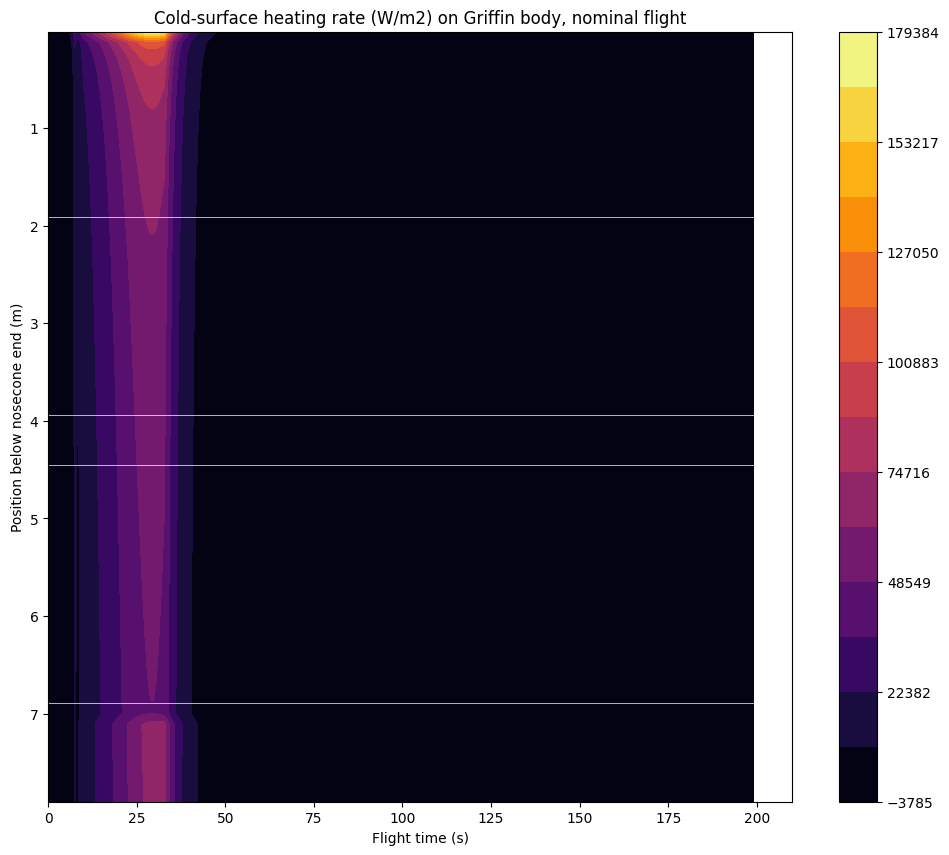

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

max_heatrate = np.nanmax(body_flow["upper bay HTC"]*(body_flow["upper bay recovery temperature"]-298))
min_heatrate = np.nanmin(body_flow["upper bay HTC"]*(body_flow["upper bay recovery temperature"]-298))
lvls = np.linspace(min_heatrate, max_heatrate, 15)

ox_array = body_flow["ox tank HTC"]*(body_flow["ox tank recovery temperature"]-298)
print(np.nanmax(body_flow["ox tank HTC"]*(body_flow["ox tank recovery temperature"]-298)))
print(np.argmax(body_flow["ox tank HTC"]*(body_flow["ox tank recovery temperature"]-298), axis=-1))
indices = np.where(ox_array == ox_array.max())
print(indices)

plt.contourf(body_flow["time"], body_flow["upper bay positions"], 
             body_flow["upper bay HTC"]*(body_flow["upper bay recovery temperature"]-298),
             levels=lvls, cmap="inferno")
plt.contourf(body_flow["time"], body_flow["ox tank positions"], 
             body_flow["ox tank HTC"]*(body_flow["ox tank recovery temperature"]-298),
              levels=lvls, cmap="inferno")
plt.contourf(body_flow["time"], body_flow["intertank bay positions"], 
             body_flow["intertank bay HTC"]*(body_flow["intertank bay recovery temperature"]-298),
              levels=lvls, cmap="inferno")
plt.contourf(body_flow["time"], body_flow["fuel tank positions"], 
             body_flow["fuel tank HTC"]*(body_flow["fuel tank recovery temperature"]-298),
              levels=lvls, cmap="inferno")
plt.contourf(body_flow["time"], body_flow["aft bay positions"], 
             body_flow["aft bay HTC"]*(body_flow["aft bay recovery temperature"]-298),
              levels=lvls, cmap="inferno")

plt.hlines([1.905, 3.942, 4.452, 6.889], xmin=0, xmax=200, colors=["w","w","w","w"], linewidth=0.5)

plt.xlabel("Flight time (s)")
plt.ylabel("Position below nosecone end (m)")
plt.title("Cold-surface heating rate (W/m2) on Griffin body, nominal flight")

plt.gca().invert_yaxis()
plt.colorbar()

# Transient thermal modelling of body - metal

https://www.researchgate.net/publication/301440650_CFD_Extraction_of_Heat_Transfer_Coefficient_in_Cryogenic_Propellant_Tanks

In [ ]:
def propellant_flux(wall_temp, propellant_temp, propellant_height, acceleration, lox=True):
  if lox:
    mu = 5.2050e-5
    k = 0.0705
    cp = 3388
    rho = 750
    beta = 3.23e-8
  else:
    # IPA
    mu = 2.3703e-3
    k = 0.137
    cp = 212
    rho = 790
    beta = 4.6e-10 # Same as water?
  
  if wall_temp == propellant_temp:
    return(0)
  
  diffusivity = k / (cp * rho)
  nu = mu / rho

  Ra = acceleration * beta * abs(wall_temp - propellant_temp) * np.power(propellant_height,3) / (diffusivity * nu)

  if Ra < 1e9:
    Nu = 0.59 * np.power(Ra, 0.25)
  else:
    Nu = 0.13 * np.power(Ra, 1/3)
  
  HTC = Nu * propellant_height / k

  Q = HTC * (propellant_temp - wall_temp) * np.sign(wall_temp - propellant_temp)

  return(Q)

In [ ]:
ox_positions = []
fuel_positions = []
ox_depths = []
fuel_depths = []
for time in trajectory["time"]:
  if time > propellant_drain_time:
    prop_level = 0
  else:
    prop_level = 1 - (time / propellant_drain_time)
  
  ox_depth = (ox_tank_length/1.1)*(prop_level)
  fuel_depth = (fuel_tank_length/1.1)*(prop_level)

  ox_positions.append(upper_bay_length + ox_tank_length - ox_depth)
  fuel_positions.append(upper_bay_length + ox_tank_length + intertank_bay_length + fuel_tank_length - fuel_depth)
  ox_depths.append(ox_depth)
  fuel_depths.append(fuel_depth)

In [ ]:
upper_bay_wall_temperature = [[298] for station in range(upper_bay_n_stations)]
ox_tank_wall_temperature = [[145] for station in range(ox_tank_n_stations)]
intertank_bay_wall_temperature = [[298] for station in range(intertank_bay_n_stations)]
fuel_tank_wall_temperature = [[298] for station in range(fuel_tank_n_stations)]
aft_bay_wall_temperature = [[298] for station in range(aft_bay_n_stations)]

Q_into_lox = [0]
Q_into_fuel = [0]

timestep = trajectory["time"][1] - trajectory["time"][0]

for step in range(1, len(trajectory["time"])):
  # ALL FLUXES ARE INTO THE STATION
  # Upper bay first - no backing, all heat goes into material
  for station in range(upper_bay_n_stations):
    T_wall_UB = upper_bay_wall_temperature[station][step-1]

    Q_conv = body_flow["upper bay HTC"][station][step]*(body_flow["upper bay recovery temperature"][station][step]-T_wall_UB)
    Q_rad = SB_const * upper_bay_emissivity * (np.power(T_rad_background,4) - np.power(T_wall_UB,4))

    Q_cond = 0
    if station == 0:
      Q_cond += (upper_bay_wall_temperature[station+1][step-1] - T_wall_UB) / upper_bay_axial_thermal_resistance
    elif station == upper_bay_n_stations - 1:
      Q_cond += (upper_bay_wall_temperature[station-1][step-1] - T_wall_UB) / upper_bay_axial_thermal_resistance
      Q_cond += (ox_tank_wall_temperature[0][step-1] - T_wall_UB) / bay_tank_thermal_resistance
    else:
      Q_cond += (upper_bay_wall_temperature[station-1][step-1] - T_wall_UB) / upper_bay_axial_thermal_resistance
      Q_cond += (upper_bay_wall_temperature[station+1][step-1] - T_wall_UB) / upper_bay_axial_thermal_resistance

    dE = (Q_conv + Q_rad + Q_cond) * timestep
    dT = dE / upper_bay_thermal_inertia

    upper_bay_wall_temperature[station].append(T_wall_UB + dT)
  
  # Intertank bay, same as upper bay
  for station in range(intertank_bay_n_stations):
    T_wall_IB = intertank_bay_wall_temperature[station][step-1]

    Q_conv = body_flow["intertank bay HTC"][station][step]*(body_flow["intertank bay recovery temperature"][station][step]-T_wall_IB)
    Q_rad = SB_const * upper_bay_emissivity * (np.power(T_rad_background,4) - np.power(T_wall_IB,4))

    Q_cond = 0
    if station == 0:
      Q_cond += (ox_tank_wall_temperature[-1][step-1] - T_wall_IB) / bay_tank_thermal_resistance
      Q_cond += (intertank_bay_wall_temperature[station+1][step-1] - T_wall_IB) / intertank_bay_axial_thermal_resistance
    elif station == intertank_bay_n_stations - 1:
      Q_cond += (intertank_bay_wall_temperature[station-1][step-1] - T_wall_IB) / intertank_bay_axial_thermal_resistance
      Q_cond += (fuel_tank_wall_temperature[0][step-1] - T_wall_IB) / bay_tank_thermal_resistance
    else:
      Q_cond += (intertank_bay_wall_temperature[station-1][step-1] - T_wall_IB) / intertank_bay_axial_thermal_resistance
      Q_cond += (intertank_bay_wall_temperature[station+1][step-1] - T_wall_IB) / intertank_bay_axial_thermal_resistance

    dE = (Q_conv + Q_rad + Q_cond) * timestep
    dT = dE / intertank_bay_thermal_inertia

    intertank_bay_wall_temperature[station].append(T_wall_IB + dT)
  
  # Aft bay, same as upper bay
  for station in range(aft_bay_n_stations):
    T_wall_AB = aft_bay_wall_temperature[station][step-1]

    Q_conv = body_flow["aft bay HTC"][station][step]*(body_flow["aft bay recovery temperature"][station][step]-T_wall_AB)
    Q_rad = SB_const * upper_bay_emissivity * (np.power(T_rad_background,4) - np.power(T_wall_AB,4))

    Q_cond = 0
    if station == 0:
      Q_cond += (fuel_tank_wall_temperature[-1][step-1] - T_wall_AB) / bay_tank_thermal_resistance
      Q_cond += (aft_bay_wall_temperature[station+1][step-1] - T_wall_AB) / aft_bay_axial_thermal_resistance
    elif station == aft_bay_n_stations - 1:
      Q_cond += (aft_bay_wall_temperature[station-1][step-1] - T_wall_AB) / aft_bay_axial_thermal_resistance
    else:
      Q_cond += (aft_bay_wall_temperature[station-1][step-1] - T_wall_AB) / aft_bay_axial_thermal_resistance
      Q_cond += (aft_bay_wall_temperature[station+1][step-1] - T_wall_AB) / aft_bay_axial_thermal_resistance

    dE = (Q_conv + Q_rad + Q_cond) * timestep
    dT = dE / aft_bay_thermal_inertia

    aft_bay_wall_temperature[station].append(T_wall_AB + dT)
  
  # LOX tank, includes heat transfer to the inner wall
  # Neglect the thermal resistance of the wall itself - the Biot number is approximately 0.05 so assume homogenous
  total_LOX_Q = 0
  for station in range(ox_tank_n_stations):
    T_wall_OT = ox_tank_wall_temperature[station][step-1]

    Q_conv = body_flow["ox tank HTC"][station][step]*(body_flow["ox tank recovery temperature"][station][step]-T_wall_OT)
    Q_rad = SB_const * ox_tank_emissivity * (np.power(T_rad_background,4) - np.power(T_wall_OT,4))

    Q_cond = 0
    if station == 0:
      Q_cond += (upper_bay_wall_temperature[-1][step-1] - T_wall_OT) / bay_tank_thermal_resistance
      Q_cond += (ox_tank_wall_temperature[station+1][step-1] - T_wall_OT) / ox_tank_axial_thermal_resistance
    elif station == ox_tank_n_stations - 1:
      Q_cond += (ox_tank_wall_temperature[station-1][step-1] - T_wall_OT) / ox_tank_axial_thermal_resistance
      Q_cond += (intertank_bay_wall_temperature[0][step-1] - T_wall_OT) / bay_tank_thermal_resistance
    else:
      Q_cond += (ox_tank_wall_temperature[station-1][step-1] - T_wall_OT) / ox_tank_axial_thermal_resistance
      Q_cond += (ox_tank_wall_temperature[station+1][step-1] - T_wall_OT) / ox_tank_axial_thermal_resistance
    
    if body_flow["ox tank positions"][station] > ox_positions[step]:
      # LOX is below the level
      Q_prop = propellant_flux(T_wall_OT, lox_temperature_K, ox_depths[step], trajectory["acceleration"][step], lox=True)
    else:
      Q_prop = 0
    
    dE = (Q_conv + Q_rad + Q_prop + Q_cond) * timestep
    dT = dE / ox_tank_thermal_inertia

    A_station = (ox_tank_length / ox_tank_n_stations) * 2 * np.pi * body_radius
    total_LOX_Q += Q_prop * A_station

    ox_tank_wall_temperature[station].append(T_wall_OT + dT)
  
  Q_into_lox.append(total_LOX_Q)
  
  # Fuel tank, includes heat transfer to the inner wall
  # Neglect the thermal resistance of the wall itself - the Biot number is approximately 0.05 so assume homogenous
  total_fuel_Q = 0
  for station in range(fuel_tank_n_stations):
    T_wall_FT = fuel_tank_wall_temperature[station][step-1]

    Q_conv = body_flow["fuel tank HTC"][station][step]*(body_flow["fuel tank recovery temperature"][station][step]-T_wall_FT)
    Q_rad = SB_const * fuel_tank_emissivity * (np.power(T_rad_background,4) - np.power(T_wall_FT,4))
    
    if body_flow["fuel tank positions"][station] > fuel_positions[step]:
      # Fuel is below the level
      Q_prop = propellant_flux(T_wall_FT, fuel_temperature_K, fuel_depths[step], trajectory["acceleration"][step], lox=False)
    else:
      Q_prop = 0
    
    Q_cond = 0
    if station == 0:
      Q_cond += (intertank_bay_wall_temperature[-1][step-1] - T_wall_FT) / bay_tank_thermal_resistance
      Q_cond += (fuel_tank_wall_temperature[station+1][step-1] - T_wall_FT) / fuel_tank_axial_thermal_resistance
    elif station == fuel_tank_n_stations - 1:
      Q_cond += (fuel_tank_wall_temperature[station-1][step-1] - T_wall_FT) / fuel_tank_axial_thermal_resistance
      Q_cond += (aft_bay_wall_temperature[0][step-1] - T_wall_FT) / bay_tank_thermal_resistance
    else:
      Q_cond += (fuel_tank_wall_temperature[station-1][step-1] - T_wall_FT) / fuel_tank_axial_thermal_resistance
      Q_cond += (fuel_tank_wall_temperature[station+1][step-1] - T_wall_FT) / fuel_tank_axial_thermal_resistance
    
    dE = (Q_conv + Q_rad + Q_prop + Q_cond) * timestep
    dT = dE / fuel_tank_thermal_inertia

    A_station = (fuel_tank_length / fuel_tank_n_stations) * 2 * np.pi * body_radius
    total_fuel_Q += Q_prop * A_station

    fuel_tank_wall_temperature[station].append(T_wall_FT + dT)
  
  Q_into_fuel.append(total_fuel_Q)

body_transient = {}
body_transient["time"] = trajectory["time"]
body_transient["upper bay temperature"] = np.array(upper_bay_wall_temperature)
body_transient["ox tank temperature"] = np.array(ox_tank_wall_temperature)
body_transient["intertank bay temperature"] = np.array(intertank_bay_wall_temperature)
body_transient["fuel tank temperature"] = np.array(fuel_tank_wall_temperature)
body_transient["aft bay temperature"] = np.array(aft_bay_wall_temperature)

body_transient["body tube temperature"] = np.concatenate((body_transient["upper bay temperature"], 
                                                          body_transient["ox tank temperature"], 
                                                          body_transient["intertank bay temperature"], 
                                                          body_transient["fuel tank temperature"],
                                                          body_transient["aft bay temperature"]))
body_transient["body tube positions"] = np.concatenate((body_flow["upper bay positions"],
                                                        body_flow["ox tank positions"],
                                                        body_flow["intertank bay positions"],
                                                        body_flow["fuel tank positions"],
                                                        body_flow["aft bay positions"]))

body_transient["heat into ox"] = np.array(Q_into_lox)
body_transient["heat into fuel"] = np.array(Q_into_fuel)

In [ ]:
# Printing temperatures at each station
# print("Upper Bay:", sep="\n")
# for station in range(upper_bay_n_stations):
#   max_T = max(upper_bay_wall_temperature[station])
#   print(f"station: {station}  max temp: {max_T - 273} C  time: {upper_bay_wall_temperature[station].index(max_T)/2}")
  

print("\n Ox tank", sep="\n")

for station in range(ox_tank_n_stations):
  max_T = max(ox_tank_wall_temperature[station])
  print(f"station: {station}  max temp: {max_T - 273} C  time: {ox_tank_wall_temperature[station].index(max_T)/2}.    At 12s: {ox_tank_wall_temperature[station][24]-273}, At 32s: {ox_tank_wall_temperature[station][64]-273}")

print()

# for station in range(intertank_bay_n_stations):
#   max_T = max(intertank_bay_wall_temperature[station])
#   print(f"station: {station}  max temp: {max_T - 273} C  time: {intertank_bay_wall_temperature[station].index(max_T)/2}")

print()

for station in range(fuel_tank_n_stations):
  max_T = max(fuel_tank_wall_temperature[station])
  print(f"station: {station}  max temp: {max_T - 273} C  time: {fuel_tank_wall_temperature[station].index(max_T)/2}.    At 12s: {fuel_tank_wall_temperature[station][24]-273}, At 32s: {fuel_tank_wall_temperature[station][64]-273}")


 Ox tank
station: 0  max temp: 216.90730660645897 C  time: 59.0.    At 12s: -40.39728810489663, At 32s: 156.61618724074623
station: 1  max temp: 194.69932682977833 C  time: 49.5.    At 12s: -45.88926347151343, At 32s: 145.88153272395118
station: 2  max temp: 192.3612116176024 C  time: 49.5.    At 12s: -46.57260094127767, At 32s: 144.0043429644041
station: 3  max temp: 189.88247085562023 C  time: 49.5.    At 12s: -48.42718856948946, At 32s: 141.75453679026373
station: 4  max temp: 186.11066306382617 C  time: 50.0.    At 12s: -53.9061524874611, At 32s: 137.98915917121906
station: 5  max temp: 180.91309110908776 C  time: 50.5.    At 12s: -63.123245704343276, At 32s: 132.59107932121412
station: 6  max temp: 173.84776571195084 C  time: 51.0.    At 12s: -77.17767787738362, At 32s: 125.04556362801617
station: 7  max temp: 165.25955544742084 C  time: 51.5.    At 12s: -95.00475149164836, At 32s: 115.76486106578727
station: 8  max temp: 155.6571672513261 C  time: 52.0.    At 12s: -115.315897388

In [ ]:
plt.plot(body_flow["time"], body_transient["ox tank temperature"][0]-273, label="ox")
plt.plot(body_flow["time"], body_transient["fuel tank temperature"][0]-273, label="fuel")
print(np.amax(body_transient["ox tank temperature"]-273))
print(np.amax(body_transient["fuel tank temperature"]-273))
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

maxT = 940-273
minT = 140-273
lvls = np.linspace(minT, maxT, 17)

print(np.amax(body_transient["upper bay temperature"])-273)

plt.contourf(trajectory["time"], body_transient["body tube positions"],  body_transient["body tube temperature"]-273,
             levels=lvls, cmap="inferno")
plt.colorbar()

plt.plot(trajectory["time"], ox_positions, label="LOX level")
plt.plot(trajectory["time"], fuel_positions, label="Fuel level")
plt.text(190, 0.9525, "Upper bay", verticalalignment="center", rotation="vertical")
plt.text(190, 2.9235, "LOX tank" , verticalalignment="center", rotation="vertical")
plt.text(190, 4.1970, "Intertank", verticalalignment="center", rotation="vertical")
plt.text(190, 5.6705, "Fuel bay" , verticalalignment="center", rotation="vertical")
plt.text(190, 7.3965, "Aft bay"  , verticalalignment="center", rotation="vertical")

# 50%, 25% and 0% strength lines for Alu 7075-T6
"""plt.contour(trajectory["time"], body_transient["body tube positions"],  body_transient["body tube temperature"]-273,
             levels=[135.9, 196, 477], colors=["k", "k"], linestyles=["dotted", "dashed", "solid"])"""

# 50%, 25% and 0% strength lines for SS-316L
plt.contour(trajectory["time"], body_transient["body tube positions"],  body_transient["body tube temperature"]-273,
levels=[748.07, 987.5, 1371], colors=["k", "k"], linestyles=["dotted", "dashed", "solid"])

plt.legend()

plt.xlabel("Flight time (s)")
plt.ylabel("Position below nosecone end (m)")
plt.title("Transient simulated temperature, degC, Griffin nominal flight, 0.5mm steel on bays")

plt.gca().invert_yaxis()



In [ ]:
cum_heat_into_ox = np.array([np.trapz(-body_transient["heat into ox"][0:i], dx=timestep) for i in range(len(trajectory["time"]))])
cum_heat_into_fuel = np.array([np.trapz(-body_transient["heat into fuel"][0:i], dx=timestep) for i in range(len(trajectory["time"]))])

In [ ]:
plt.plot(trajectory["time"], -body_transient["heat into ox"])
plt.plot(trajectory["time"], -body_transient["heat into fuel"])
plt.xlabel("Flight time (s)")
plt.ylabel("Heat into LOX (W)")

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(trajectory["time"], -body_transient["heat into ox"]/1000, "g-")
ax2.plot(trajectory["time"], -body_transient["heat into ox"]/100e3, 'b-')

plt.title("LOX boiloff modelling")
ax1.set_xlabel('Flight time (s)')
ax1.set_ylabel('Heat flux into LOX tank (kW)', color='g')
#ax1.set_ylim(0, 5e6)
ax2.set_ylim(0, 1)
ax2.set_ylabel('Approximate boiloff rate (kg/s)', color='b')
plt.xlim(0, 50)

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
plt.contourf(body_flow["time"], body_flow["fuel tank positions"], 
             body_transient["fuel tank temperature"]-273,
              cmap="inferno", levels=np.arange(-160, 160, 20))
plt.colorbar()

plt.contour(body_flow["time"], body_flow["fuel tank positions"], 
             body_transient["fuel tank temperature"]-273,
              colors=["k", "k"], levels=[0, 100])

plt.xlim(0, 100)
plt.gca().invert_yaxis()


In [ ]:
plt.contourf(body_flow["time"], body_flow["ox tank positions"], 
             (body_flow["ox tank recovery temperature"]-145),
              cmap="inferno")

plt.xlim(0, 50)

plt.colorbar()

In [ ]:

#plt.plot(trajectory["time"], cum_heat_into_ox/100e3, secondary_y=True)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(trajectory["time"], cum_heat_into_ox/1e3, "g-")
ax2.plot(trajectory["time"], cum_heat_into_ox/100e3, 'b-')

plt.title("Cumulative boiloff")
ax1.set_xlabel('Flight time (s)')
ax1.set_ylabel('Total heat (kJ)', color='g')
#ax1.set_ylim(0, 5e6)
ax2.set_ylim(0, 15)
ax2.set_ylabel('Approximate boiloff (kg)', color='b')

# Non-conduction transient thermal modelling of fins - metal

In [ ]:
LE_wall_temperature = [298] 
wedge1_wall_temperature = [[298] for station in range(wedge1_n_stations)]
wedge2_wall_temperature = [[298] for station in range(wedge2_n_stations)]
wedge3_wall_temperature = [[298] for station in range(wedge3_n_stations)]

print(wedge1_wall_temperature)

timestep = trajectory["time"][1] - trajectory["time"][0]

for step in range(1, len(fins_flow["time"])):

  # Leading edge temperature
  T_wall_LE = LE_wall_temperature[step-1]

  Q_conv = fins_flow["leading edge HTC"][step]*(fins_flow["leading edge recovery temperature"][step]-T_wall_LE)
  Q_rad = SB_const * LE_emissivity * (np.power(T_rad_background,4) - np.power(T_wall_LE,4))

  dE = (Q_conv + Q_rad) * timestep
  dT = dE / LE_thermal_inertia

  LE_wall_temperature.append(T_wall_LE + dT)

  
  for station in range(wedge1_n_stations):
    T_wall_W1 = wedge1_wall_temperature[station][step-1]

    Q_conv = fins_flow["wedge 1 HTC"][station][step]*(fins_flow["wedge 1 recovery temperature"][station][step]-T_wall_W1)
    Q_rad = SB_const * wedge1_emissivity * (np.power(T_rad_background,4) - np.power(T_wall_W1,4))

    dE = (Q_conv + Q_rad) * timestep
    dT = dE / wedge1_thermal_inertia

    wedge1_wall_temperature[station].append(T_wall_W1 + dT)
  
  for station in range(wedge2_n_stations):
    T_wall_W2 = wedge2_wall_temperature[station][step-1]

    Q_conv = fins_flow["wedge 2 HTC"][station][step]*(fins_flow["wedge 2 recovery temperature"][station][step]-T_wall_W2)
    Q_rad = SB_const * wedge2_emissivity * (np.power(T_rad_background,4) - np.power(T_wall_W2,4))

    dE = (Q_conv + Q_rad) * timestep
    dT = dE / wedge2_thermal_inertia

    wedge2_wall_temperature[station].append(T_wall_W2 + dT)
  
  for station in range(wedge3_n_stations):
    T_wall_W3 = wedge3_wall_temperature[station][step-1]

    Q_conv = fins_flow["wedge 3 HTC"][station][step]*(fins_flow["wedge 3 recovery temperature"][station][step]-T_wall_W3)
    Q_rad = SB_const * wedge3_emissivity * (np.power(T_rad_background,4) - np.power(T_wall_W3,4))

    dE = (Q_conv + Q_rad) * timestep
    dT = dE / wedge3_thermal_inertia

    wedge3_wall_temperature[station].append(T_wall_W3 + dT)
  
fins_transient = {}
fins_transient["time"] = trajectory["time"]

fins_transient["leading edge wall temperature"] = np.array(LE_wall_temperature)
fins_transient["wedge 1 wall temperature"] = np.array(wedge1_wall_temperature)
fins_transient["wedge 2 wall temperature"] = np.array(wedge2_wall_temperature)
fins_transient["wedge 3 wall temperature"] = np.array(wedge3_wall_temperature)

fins_transient["fin wall temperature"] = np.concatenate((
    [fins_transient["leading edge wall temperature"]],
    fins_transient["wedge 1 wall temperature"],
    fins_transient["wedge 2 wall temperature"],
    fins_transient["wedge 3 wall temperature"]
))

fins_transient["fin wall positions"] = np.concatenate((
    np.array([0]),
    fins_flow["wedge 1 station position"],
    fins_flow["wedge 2 station position"],
    fins_flow["wedge 3 station position"]
))

wedge1_wall_temperature = []
wedge2_wall_temperature = []
wedge3_wall_temperature = []

[[298], [298], [298], [298], [298], [298], [298], [298]]


645.1766197488271


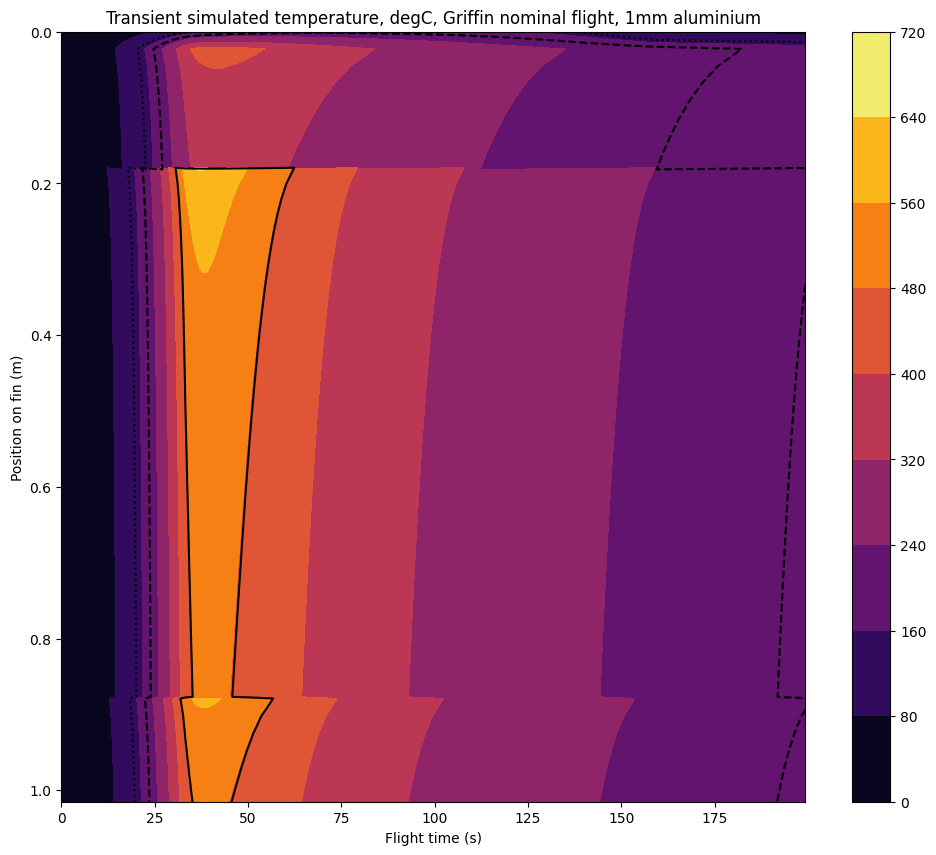

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

plt.contourf(fins_transient["time"], fins_transient["fin wall positions"], fins_transient["fin wall temperature"]-273, cmap="inferno")
plt.colorbar()

# 50%, 25% and 0% strength lines for SS-316L
"""plt.contour(fins_transient["time"], fins_transient["fin wall positions"], fins_transient["fin wall temperature"]-273,
  levels=[748.07, 987.5, 1371], colors=["k", "k"], linestyles=["dotted", "dashed", "solid"])"""

plt.contour(fins_transient["time"], fins_transient["fin wall positions"],  fins_transient["fin wall temperature"]-273,
             levels=[135.9, 196, 477], colors=["k", "k"], linestyles=["dotted", "dashed", "solid"])

print(np.amax(fins_transient["fin wall temperature"]-273))

plt.ylim(0, aft_bay_length)
plt.xlabel("Flight time (s)")
plt.ylabel("Position on fin (m)")
plt.title("Transient simulated temperature, degC, Griffin nominal flight, 1mm aluminium")


plt.gca().invert_yaxis()

# Transient conduction test - ensuring conservation of energy etc

https://people.sc.fsu.edu/~jburkardt/py_src/fd1d_heat_implicit/fd1d_heat_implicit.html
Implicit 1D scheme used

In [ ]:
def fd1d_heat_implicit_cfl ( k, t_num, t_min, t_max, x_num, x_min, x_max ):

#*****************************************************************************80
#
## fd1d_heat_implicit_cfl(): compute the Courant-Friedrichs-Loewy coefficient.
#
#  Discussion:
#
#    The equation to be solved has the form:
#
#      dUdT - k * d2UdX2 = F(X,T)
#
#    over the interval [X_MIN,X_MAX] with boundary conditions
#
#      U(X_MIN,T) = U_X_MIN(T),
#      U(X_MIN,T) = U_X_MAX(T),
#
#    over the time interval [T_MIN,T_MAX] with initial conditions
#
#      U(X,T_MIN) = U_T_MIN(X)
#
#    The code uses the finite difference method to approximate the
#    second derivative in space, and an explicit forward Euler approximation
#    to the first derivative in time.
#
#    The finite difference form can be written as
#
#      U(X,T+dt) - U(X,T)                  ( U(X-dx,T) - 2 U(X,T) + U(X+dx,T) )
#      ------------------  = F(X,T) + k *  ------------------------------------
#               dt                                   dx * dx
#
#    or, assuming we have solved for all values of U at time T, we have
#
#      U(X,T+dt) = U(X,T) + cfl * ( U(X-dx,T) - 2 U(X,T) + U(X+dx,T) ) + dt * F(X,T) 
#
#    Here "cfl" is the Courant-Friedrichs-Loewy coefficient:
#
#      cfl = k * dt / dx / dx
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license. 
#
#  Modified:
#
#    14 April 2017
#
#  Author:
# 
#    John Burkardt
#
#  Reference:
#
#    George Lindfield, John Penny,
#    Numerical Methods Using MATLAB,
#    Second Edition,
#    Prentice Hall, 1999,
#    ISBN: 0-13-012641-1,
#    LC: QA297.P45.
#
#  Input:
#
#    real K, the heat conductivity coefficient.
#
#    integer T_NUM, the number of time values, including the initial
#    value.
#
#    real T_MIN, T_MAX, the minimum and maximum times.
#
#    integer X_NUM, the number of nodes.
#
#    real X_MIN, X_MAX, the minimum and maximum spatial coordinates.
#
#  Output:
#
#    real CFL, the Courant-Friedrichs-Loewy coefficient.
#
  x_step = ( x_max - x_min ) / float ( x_num - 1 )
  t_step = ( t_max - t_min ) / float ( t_num - 1 )
  cfl = k * t_step / x_step / x_step

  return cfl

def fd1d_heat_implicit_matrix ( x_num, cfl ):

#*****************************************************************************80
#
## fd1d_heat_implicit_matrix(): set the system matrix.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    14 April 2017
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    integer X_NUM, the number of nodes.
#
#    real CFL, the Courant-Friedrichs-Loewy coefficient.
#
#  Output:
#
#    real A(X_NUM,X_NUM), the system matrix.
#
  import numpy as np

  a = np.zeros ( ( x_num, x_num ) )

  a[0,0] = 1.0

  for i in range ( 1, x_num - 1 ):
    a[i,i-1] =           - cfl
    a[i,i  ] = 1.0 + 2.0 * cfl
    a[i,i+1] =           - cfl

  a[x_num-1,x_num-1] = 1.0

  return a

def fd1d_heat_implicit ( a, x_num, x, t, dt, cfl, rhs_fun, bc_fun, u ):

#*****************************************************************************80
#
## fd1d_heat_implicit(): Finite difference solution of 1D heat equation.
#
#  Discussion:
#
#    fd1d_heat_implicit solves the 1D heat equation with an implicit method.
#
#    This program solves
#
#      dUdT - k * d2UdX2 = F(X,T)
#
#    over the interval [A,B] with boundary conditions
#
#      U(A,T) = UA(T),
#      U(B,T) = UB(T),
#
#    over the time interval [T0,T1] with initial conditions
#
#      U(X,T0) = U0(X)
#
#    The code uses the finite difference method to approximate the
#    second derivative in space, and an implicit backward Euler approximation
#    to the first derivative in time.
#
#    The finite difference form can be written as
#
#      U(X,T+dt) - U(X,T)                  ( U(X-dx,T+dt) - 2 U(X,T+dt) + U(X+dx,T+dt) )
#      ------------------ = F(X,T+dt) + k *  --------------------------------------
#               dt                                   dx * dx
#
#    so that we have the following linear system for the values of U at time T+dt:
#
#            -     k * dt / dx / dx   * U(X-dt,T+dt)
#      + ( 1 + 2 * k * dt / dx / dx ) * U(X,   T+dt)
#            -     k * dt / dx / dx   * U(X+dt,T+dt)
#      =               dt             * F(X,   T+dt)
#      +                                U(X,   T)
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    14 April 2017
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    real A(X_NUM,X_NUM), the system matrix.
#
#    integer X_NUM, the number of nodes.
#
#    real X(X_NUM), the node coordinates.
#
#    real T, the current time.
#
#    real DT, the size of the time step.
#
#    real CFL, the Courant-Friedrichs-Loewy coefficient.
#
#    f = rhs_FUN ( x_num, x, t ), returns in F the right hand side
#    forcing function at every non-boundary node.
#
#    hbc = bc_FUN ( x_num, x, t, h ), returns in HBC a copy of the
#    input solution H, after imposing Dirichlet boundary conditions.
#
#    real U(X_NUM), the solution values at the old time.
#
#  Output:
#
#    real U(X_NUM), the solution values at the new time.
#

#
#  Compute b, the right hand side of the system.
#
  fvec = rhs_fun ( x_num, x, t )

  b = u.copy ( )
  for i in range ( 1, x_num - 1 ):
    b[i] = b[i] + dt * fvec[i]
#
#  Solve A*u=b.
#
  u = np.linalg.solve ( a, b )
#
#  Impose boundary conditions on U.
#
  u = bc_fun ( x_num, x, t, u )

  return u

def rhs_test01 ( x_num, x, t ):

#*****************************************************************************80
#
## rhs_test01() evaluates the right hand side for problem 1.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license. 
#
#  Modified:
#
#    25 January 2012
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    integer X_NUM, the number of nodes.
#
#    real X(X_NUM), the node coordinates.
#
#    real T, the current time.
#
#  Output:
#
#    real VALUE(X_NUM), the source term.
#

  value = np.zeros ( x_num )

  return value

def bc_test01 ( x_num, x, t, h ):

#*****************************************************************************80
#
## bc_test01() evaluates the boundary conditions for problem 1.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license. 
#
#  Modified:
#
#    25 January 2012
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    integer X_NUM, the number of nodes.
#
#    real X(X_NUM), the node coordinates.
#
#    real T, the current time.
#
#    real H(X_NUM), the current heat values.
#
#  Output:
#
#    real H(X_NUM), the current heat values, after boundary
#    conditions have been imposed.
#
  h[0]       = 90.0
  h[x_num-1] = 70.0

  return h

In [ ]:
x_num = 10
x_min = 0
x_max = 0.2
dx = (x_max - x_min) / (x_num-1)
x = np.linspace(x_min, x_max, x_num)


flux_into_P1 = 1 - 0.01 * np.power(t-10,2)
flux_into_P3 = 0.01 * np.power(t-10,2)

t_num = 160
t_min = 0.0
t_max = 80.0
dt = ( t_max - t_min ) / ( t_num - 1 )
t = np.linspace ( t_min, t_max, t_num )

k = 15
rho_cp = 8000*500
k /= rho_cp

cfl = fd1d_heat_implicit_cfl ( k, t_num, t_min, t_max, x_num, x_min, x_max )
print(cfl)
a = fd1d_heat_implicit_matrix ( x_num, cfl )

hmat = np.zeros ( ( x_num, t_num ) )

for j in range(0, t_num):
  if j==0:
    h = np.array([50.0 for i in range(x_num)])
    h[0] = 90
    h[x_num - 1] = 70
  else:
    h = fd1d_heat_implicit(a, x_num, x, t[j-1], dt, cfl, rhs_test01, bc_test01, h)
  
  for i in range(x_num):
    hmat[i,j] = h[i]

NameError: ignored

In [ ]:
plt.contourf(t, x, hmat)